In [61]:
import pandas as pd

data = pd.read_csv('/content/test_data.csv', delimiter=';', encoding='windows-1251')
data



,Год,Урожайность ячменя
0,1,"14,1"
1,2,"9,3"
2,3,"19,4"
3,4,"19,7"
4,5,"5,4"
5,6,"24,2"
6,7,"13,8"
7,8,"24,5"
8,9,"14,7"
9,10,"16,6"


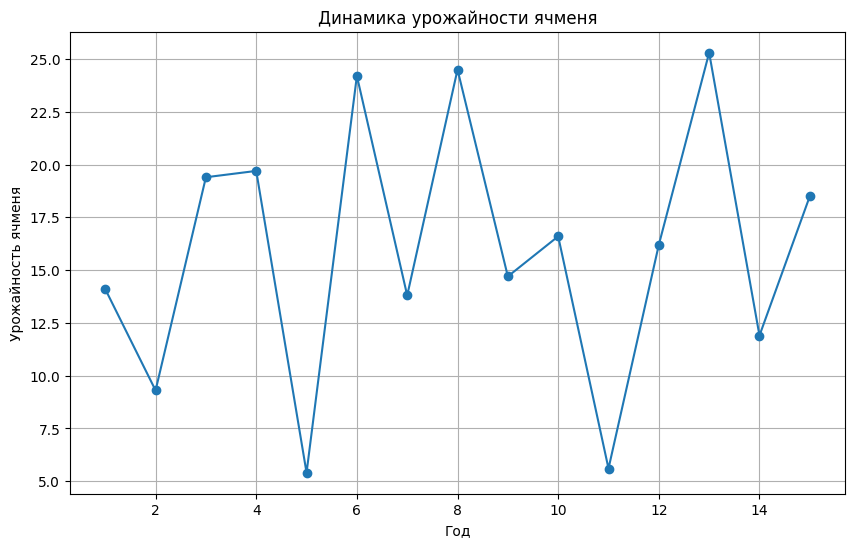

In [62]:
import matplotlib.pyplot as plt

data_column = 'Урожайность ячменя'
# Converting the "Урожайность ячменя" column to numeric, replacing comma with dot for decimal
data[data_column] = data[data_column].str.replace(',', '.').astype(float)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(data['Год'], data[data_column], marker='o')
plt.title('Динамика урожайности ячменя')
plt.xlabel('Год')
plt.ylabel('Урожайность ячменя')
plt.grid(True)
plt.show()

Критерий серий, основанный на медиане


In [63]:
median_yield = data[data_column].median()
median_yield

16.2

In [64]:
# Определение серий: значения выше или ниже медианы
above_median = data[data_column] > median_yield
series = above_median.ne(above_median.shift()).cumsum()
series_counts = series.value_counts()

# Количество серий
num_series = len(series_counts)
num_series

12

In [65]:
# Нахождение длины каждой серии
series_lengths = series.map(series.value_counts())

# Нахождение максимальной длины серии
max_series_length = series_lengths.max()
max_series_length

2

In [66]:
from math import sqrt, log10

n = len(data[data_column])
first_equel = int(1/2*(n+2-1.96*sqrt(n-1)))

second_equel = int((log10(n) + 1) * 3.3)
first_equel, second_equel

(4, 7)

In [67]:
if num_series > first_equel and max_series_length < second_equel:
  print('Ни одно из неравенств не нарушено.')
else:
  print('Нарушено одно или два неравенства.')

Ни одно из неравенств не нарушено.


Критерий «восходящих» и «нисходящих» серий

In [68]:
k_n  = 5 # стандартное значение
if n <= 26:
  k_n = 5
elif n>21 and n<=153:
  k_n = 6
elif n>153 and n<=1170:
  k_n = 7

first_equel = int((2*n - 1) / 3 - 1.96*sqrt((16*n - 29)/90))

second_equel = k_n
first_equel, second_equel

(6, 5)

In [69]:
if num_series > first_equel and max_series_length < second_equel:
  print('Ни одно из неравенств не нарушено.')
else:
  print('Нарушено одно или два неравенства.')

Ни одно из неравенств не нарушено.


Сравнение средних уровней ряда с использованием F-критерия Фишера

In [72]:
from scipy.stats import ttest_ind

# Разделение данных на две равные части
n = len(data)
half = int(n / 2)
first_half = data[data_column].iloc[:half]
second_half = data[data_column].iloc[half:]

# Расчет средних значений для каждой части
mean_first_half = first_half.mean()
mean_second_half = second_half.mean()

mean_first_half, mean_second_half, second_half

(15.12857142857143,
 16.6625,
 7     24.5
 8     14.7
 9     16.6
 10     5.6
 11    16.2
 12    25.3
 13    11.9
 14    18.5
 Name: Урожайность ячменя, dtype: float64)

In [52]:
# Расчет дисперсий для каждой части
variance_first_half = first_half.var()
variance_second_half = second_half.var()

variance_first_half, variance_second_half

(42.14571428571428, 43.58410714285714)

In [73]:
f_r = max(variance_first_half, variance_second_half) / min(variance_first_half, variance_second_half)
f_r

1.034129042098841

In [78]:
from scipy.stats import f

# Уровень значимости (alpha)
alpha = 0.05

# Табличное значение F для заданного alpha, dfn и dfd
F_critical = f.ppf(1 - alpha, half, n - half - 1)
F_critical

3.7870435399280677

In [79]:
if f_r < F_critical:
  print('тренд отсутствует')
else:
  print('тренд присутствует')

тренд отсутствует
